In [61]:
import numpy as np
import matplotlib.pyplot as plt
from Helper import readFromFile

In [62]:
# constants
playersTraining = [2, 7, 11, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, 54]
playersBaseline = [4, 9, 13, 16, 19, 24, 28, 31, 36, 39]
playersOptimal  = [3, 8, 12, 15, 21, 23, 27, 32, 35, 40]
path = "E:\\Andreea\\Master\\Thesis\\Git\\TheOne\\SmartuistWrapper\\tapResultParticipants.csv"

In [76]:
def getStatisticsPhase3(results, players):
    mvmTime = [] 
    for p in players:
        tmp = results[p]
        time = 0
        gain = []
        
        for words in tmp:
            time += float(words[10])
            gain.append(float(words[29])) #
        mvmTime.append(time/1000) # time in seconds
    return (mvmTime, gain)

In [78]:
results = readFromFile(path, 0)
mvmTimeBaseline, gainBaseline = getStatisticsPhase3(results, playersBaseline)
mvmTimeOptimal, gainOptimal = getStatisticsPhase3(results, playersOptimal)
print(mvmTimeBaseline)
print(mvmTimeOptimal)

[82.425, 65.436, 48.073, 48.616, 90.682, 34.228, 60.845, 51.345, 46.063, 39.429]
[62.501, 60.486, 39.817, 38.132, 35.152, 26.753, 57.939, 37.953, 35.432, 32.66]


Text(0, 0.5, 'Seconds')

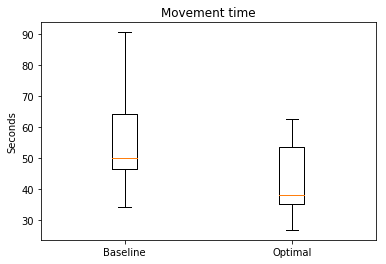

In [86]:
plt.boxplot([mvmTimeBaseline, mvmTimeOptimal], labels= ["Baseline", "Optimal"])
plt.title("Movement time")
plt.ylabel("Seconds")